In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='give your connection password,
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'copy & paste folder path'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



KeyboardInterrupt: 

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="your_password",
                           database="ecommerce")
cur= db.cursor()


# List all unique cities where customers are located

In [10]:
query="""select distinct(customer_city) from customers""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [13]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017""" 
cur.execute(query)
data=cur.fetchall()
"Total orders placed in 2017 are ",data[0][0]

('Total orders placed in 2017 are ', 45101)

# Find the total sales per category

In [17]:
query="""select products.product_category category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
""" 
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data, columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that we paid in installments.

In [20]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments""" 
cur.execute(query)
data=cur.fetchall()
data
"The percentage of orders that were paid in installments is ",data[0][0]

('The percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

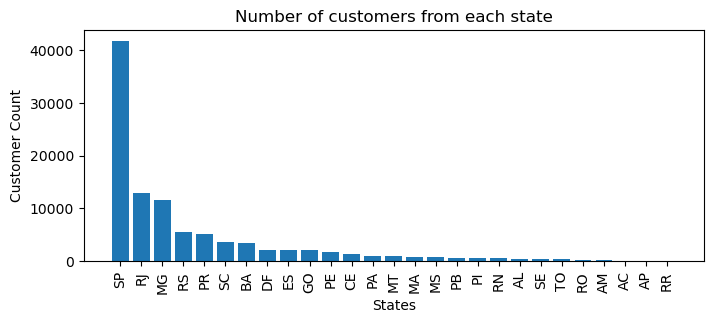

In [23]:
query="""select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["State","Customer count"])
df=df.sort_values(by="Customer count",ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df["State"],df["Customer count"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Customer Count")
plt.title("Number of customers from each state")
plt.show()

# Calculate the number of orders per month in 2018

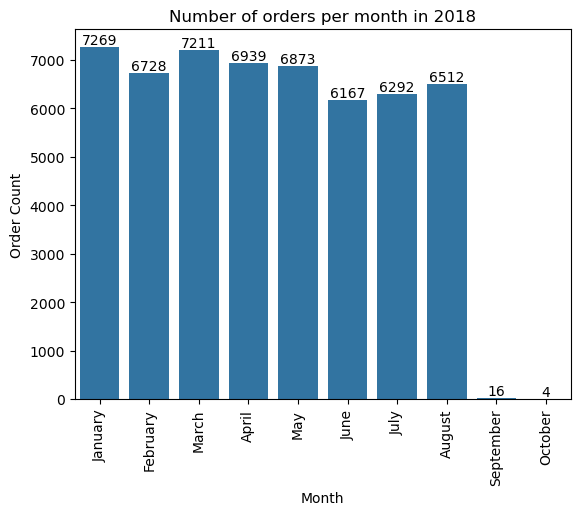

In [26]:
query="""select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders where year(order_purchase_timestamp)=2018 group by months""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month","Order Count"])
mo=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["Month"],y=df["Order Count"],data=df,order=mo)
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show() 

# Find the average number of products per order, grouped by customer city.

In [29]:
query="""with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2)
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer City","Average orders"])
df

,Customer City,Average orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


# Calculate the percentage of total revenue contributed by each category

In [42]:
query="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by sales desc
""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","% of Total Sales"])
df

,Category,% of Total Sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [54]:
query="""
select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category;
""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Order Count","Avg Price"])

arr1=df["Order Count"]
arr2=df["Avg Price"]
arr=np.corrcoef([arr1,arr2])
print("The correlation value between product price and the number of times a product has been purchased is", arr[0][1])

The correlation value between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue


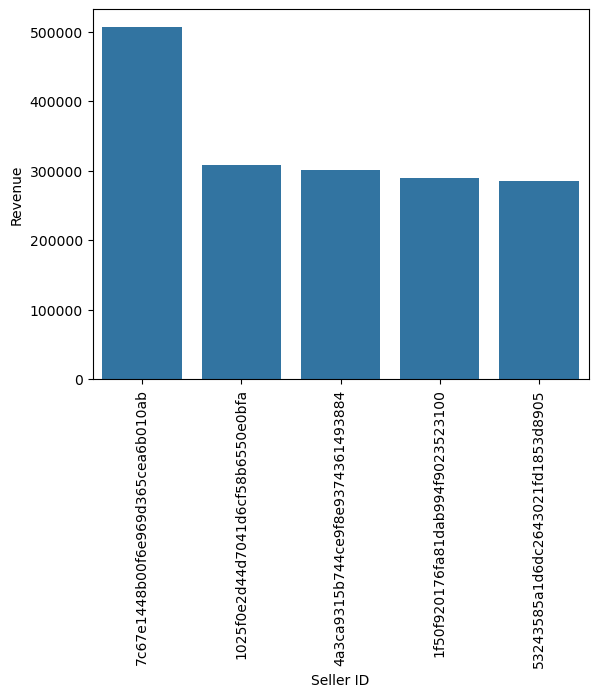

In [77]:
query=""" select *, dense_rank() over(order by revenue desc) from
(select order_items.seller_id seller,round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by seller_id) as a
""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller ID","Revenue","Rank"])
df=df.head(5)
sns.barplot(x="Seller ID",y="Revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [82]:
query=""" select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer ID","Order Purchase Timestamp","Payment","Moving Average"])
df

,Customer ID,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [124]:
query=""" 
select years,months,payment,sum(payment)
over(order by years, months) as cumilative_sales
from
(select year(order_purchase_timestamp) as years, month(order_purchase_timestamp) as months,round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id=payments.order_id
group by years,months
order by years,months) as a""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","Sales","Cumilative Sales"])
df

,Years,Months,Sales,Cumilative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [145]:
query=""" 
select years,round(((sales-lag(sales,1) over(order by years))/
lag(sales,1) over(order by years))*100,2)
from
(select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) as sales
from orders join payments
on orders.order_id=payments.order_id
group by years
order by years) as sales_per_year""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","YOY % growth"])
df

,Years,YOY % growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Identify the top 3 customers who spent the most money in each year.


In [155]:
query=""" 
select years,customer_id,money_spent,d_rank from
(select year(orders.order_purchase_timestamp) as years,orders.customer_id,round(sum(payments.payment_value),2) as money_spent,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id)as a
where d_rank<=3""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","ID","Payment","Rank"])
df

,Years,ID,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3
